# LSTM Stock Predictor Using Closing Prices

In this notebook, a custom LSTM RNN model is built and trained that uses a 3 day window of closing prices of Pharcameutical companies to predict the 4th day closing price. 

Summary of steps:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model


## 1. Data Preparation

In [ ]:
# Imports
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
# Set the random seed for reproducibility
# Note: This is for the assignment, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [4]:
# Load the closing prices 
file_path = Path('Data/df.csv')
df = pd.read_csv(file_path)
df = df.drop([1])
df.head()

,Attributes,Volume,Volume.1,Volume.2,Adj Close,Adj Close.1,Adj Close.2
0,Symbols,GSK,PFE,AZN,GSK,PFE,AZN
2,1/2/2018,9465500,16185800,6107400,32.10053253,32.92734146,31.99385643
3,1/3/2018,6600800,13456500,4195400,31.97884941,33.1713028,32.05715179
4,1/4/2018,5206400,12378100,3870900,32.03968811,33.24359894,32.1023674
5,1/5/2018,7250700,12492900,3336000,32.60468292,33.30685043,32.43695831


In [5]:
def construct_df(df, volume, adj_close):
    r_df = pd.DataFrame({"Volume": df[volume], "Adj Close": df[adj_close],
                      "Date": df["Attributes"]})
    r_df.drop([0], inplace=True)
    r_df["Volume"] = r_df["Volume"].astype(float)
    r_df["Adj Close"] = r_df["Adj Close"].astype(float)
    r_df['Percent Change'] = r_df["Adj Close"].pct_change() * 100
    r_df["Date"] = pd.to_datetime(r_df["Date"])
    r_df.drop(r_df.loc[r_df["Date"] <'2020-01-01'].index, inplace=True)
    r_df = r_df.set_index("Date")
    return r_df

In [6]:
# extract data for GSk and create a dataframe for GSk
gsk_df_dr = construct_df(df, "Volume","Adj Close")
gsk_df_dr.head()

,Volume,Adj Close,Percent Change
Date,,,
2020-01-02,2462400.0,45.229774,-0.148976
2020-01-03,2149100.0,44.805626,-0.937764
2020-01-06,2034500.0,44.824902,0.043021
2020-01-07,1718900.0,44.545349,-0.623654
2020-01-08,1766700.0,44.738148,0.432814


In [7]:
gsk_df = gsk_df_dr.drop(columns=["Volume", "Adj Close"])
gsk_df.head()

,Percent Change
Date,
2020-01-02,-0.148976
2020-01-03,-0.937764
2020-01-06,0.043021
2020-01-07,-0.623654
2020-01-08,0.432814


In [8]:
# extract data for PFE and create a dataframe for PFE
pfe_df_dr = construct_df(df, "Volume.1","Adj Close.1")
pfe_df = pfe_df_dr.drop(columns=["Volume", "Adj Close"])
pfe_df.head()

,Percent Change
Date,
2020-01-02,-0.102085
2020-01-03,-0.536539
2020-01-06,-0.128443
2020-01-07,-0.334342
2020-01-08,0.799998


In [9]:
# extract data for AZN and create a dataframe for AZN
azn_df_dr = construct_df(df, "Volume.2","Adj Close.2")
azn_df = azn_df_dr.drop(columns=["Volume", "Adj Close"])
azn_df.head()

,Percent Change
Date,
2020-01-02,1.062978
2020-01-03,-0.595353
2020-01-06,-0.419246
2020-01-07,0.380910
2020-01-08,-0.239660


In [10]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Predict closing Prices for PFE using LSTM

In [11]:

# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

feature_column = 0
target_column = 0
X, y = window_data(pfe_df, window_size, feature_column, target_column)

In [12]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)


In [14]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.45716682]
  [0.43114425]
  [0.45558804]]

 [[0.43114425]
  [0.45558804]
  [0.44325525]]

 [[0.45558804]
  [0.44325525]
  [0.51119893]]] 

X_test sample values:
[[[0.32086692]
  [0.13553249]
  [0.21123136]]

 [[0.13553249]
  [0.21123136]
  [0.2063723 ]]

 [[0.21123136]
  [0.2063723 ]
  [0.46821303]]]


## Build and Train the LSTM RNN

In this section, custom LSTM RNN is built and fit (trained) using the training data.

1. Define the model architecture
2. Compile the model
3. Fit the model to the training data



In [15]:
# Build the LSTM model. 
# The return sequences need to be set to True when adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [16]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [17]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 30)             3840      
_________________________________________________________________
dropout (Dropout)            (None, 3, 30)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 30)             7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 30)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [18]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=2, verbose=1)

Epoch 1/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0846
Epoch 2/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0323
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 6/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0300
Epoch 7/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 8/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 9/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 10/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0292
Epoch 11/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 12/20
64/64 [==============================] - 0s 5ms/step - loss: 0.0285
Epoch 13/20
64/64 [==============================

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Note
Apply the `inverse_transform` function to the predicted and y_test values to recover the actual returns.

In [19]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.0443


0.04432561248540878

In [20]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [21]:
# Recover the original returns instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [22]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = pfe_df.index[-len(real_prices): ]) 
stocks.head()


,Real,Predicted
Date,,
2020-07-10,-0.859260,0.797568
2020-07-13,1.105804,0.744166
2020-07-14,4.079205,0.789000
2020-07-15,0.056801,0.864584
2020-07-16,1.390868,0.998835


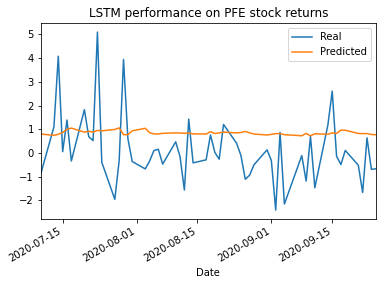

In [23]:
# Plot the real vs predicted values as a line chart

stocks.plot(title="LSTM performance on PFE stock returns")
#plt.savefig('./Images/LSTMmodel_PFE_stock_returns.png')

## Predict Closing prices for GSK using LSTM

In [75]:
###GSK###########
# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

# Column index 1 is the 'Close' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(gsk_df, window_size, feature_column, target_column)

In [76]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [77]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [78]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.53175077]
  [0.49325117]
  [0.54112184]]

 [[0.49325117]
  [0.54112184]
  [0.5085824 ]]

 [[0.54112184]
  [0.5085824 ]
  [0.5601471 ]]] 

X_test sample values:
[[[0.37680261]
  [0.19810849]
  [0.61632428]]

 [[0.19810849]
  [0.61632428]
  [0.31164086]]

 [[0.61632428]
  [0.31164086]
  [0.26715912]]]


In [79]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [80]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [81]:
# Summarize the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 3, 30)             3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 30)             7320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [88]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
6/6 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 3/20
6/6 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 5/20
6/6 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 6/20
6/6 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 7/20
6/6 [==============================] - 0s 8ms/step - loss: 0.0158
Epoch 8/20
6/6 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 9/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 10/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 11/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 12/20
6/6 [==============================] - 0s 4ms/step - loss: 0.0193
Epoch 13/20
6/6 [==============================] - 0s 5ms/step - loss: 0

In [89]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.0550


0.05496955290436745

In [90]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [91]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [92]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = gsk_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-07-10,-0.883872,0.244262
2020-07-13,-1.139452,0.241300
2020-07-14,0.400897,0.340320
2020-07-15,1.572255,0.226058
2020-07-16,3.071255,0.290591


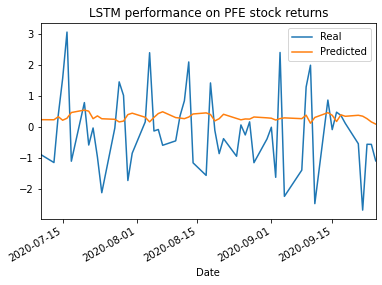

In [93]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 3
stocks.plot(title="LSTM performance on PFE stock returns")
plt.savefig('./Images/LSTMmodel_GSK_stock_returns.png')

## Predict Closing prices for AZN using LSTM

In [95]:
###AZN###########
# Predict Closing Prices using a 3 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 3

feature_column = 0
target_column = 0
X, y = window_data(azn_df, window_size, feature_column, target_column)

In [96]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [97]:
# Use the MinMaxScaler to scale data between 0 and 1.

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [98]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.61719084]
  [0.52958172]
  [0.53888543]]

 [[0.52958172]
  [0.53888543]
  [0.58115739]]

 [[0.53888543]
  [0.58115739]
  [0.54837287]]] 

X_test sample values:
[[[0.3960704 ]
  [0.24511071]
  [0.46522584]]

 [[0.24511071]
  [0.46522584]
  [0.31160322]]

 [[0.46522584]
  [0.31160322]
  [0.31308071]]]


In [99]:
# Build the LSTM model. 

# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [100]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [101]:
# Summarize the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 3, 30)             3840      
_________________________________________________________________
dropout_15 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 3, 30)             7320      
_________________________________________________________________
dropout_16 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [102]:
# Train the model

model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=4, verbose=1)

Epoch 1/20
32/32 [==============================] - 0s 8ms/step - loss: 0.1956
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0242
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 8/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 9/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0208
Epoch 10/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 11/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 12/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0209
Epoch 13/20
32/32 [==============================

In [103]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 0s 1ms/step - loss: 0.0722


0.07219988107681274

In [104]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [105]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [106]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = azn_df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-07-10,-0.405970,2.332736
2020-07-13,-0.389115,2.273741
2020-07-14,-0.967249,2.405090
2020-07-15,1.389925,2.249968
2020-07-16,7.447202,2.263069


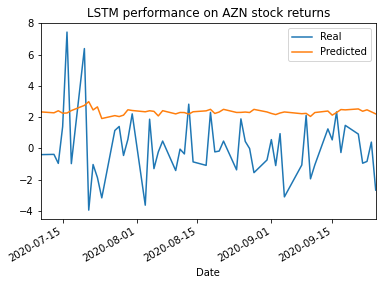

In [107]:
# Plot the real vs predicted values as a line chart
# WINDOW 3, epochs 20, batch 3
stocks.plot(title="LSTM performance on AZN stock returns")
#plt.savefig('./Images/LSTMmodel_AZN_stock_returns.png')
